### Часть 1. Модель хищник-жертва

Рассмотрим уравнения Лотки — Вольтерры для динамики популяции хищников и животных-жертв (классический пример системы ОДУ). Уравнения следующие: $x'(t) = ax - bxy$ и $y'(t) = cxy - dy$, где $x(t)$ - количество животных - жертв, а $y(t)$ - количество животных-хищников. Коэффициенты a, b, c и d описывают скорость процессов в модели. Например, $a$ - это скорость, с которой рождаются хищные животные, а $d$ - скорость, с которой хищные животные умирают. Коэффициенты $b$ и $c$ - это скорость, с которой хищники поедают добычу, и скорость, с которой популяция хищников растет за счет популяции жертвы, соответственно. Обратите внимание, что это нелинейная система ОДУ из-за членов $xy$.

Text(0, 0.5, 'Количество хищников')

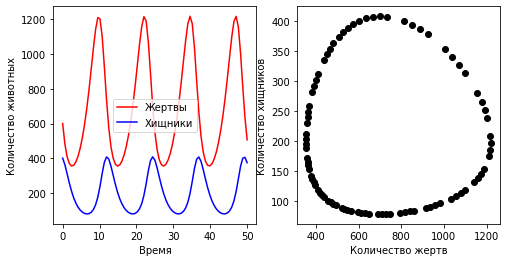

In [129]:
%matplotlib inline
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# параметры модели
a, b, c, d = 0.4, 0.002, 0.001, 0.7
# правая часть системы
def f(xy_vec, t):
    x, y = xy_vec
    return [a*x - b*x*y, c*x*y - d*y]

# начальные условия
xy_vec0 = [600, 400]
# сетка
t = np.linspace(0, 50, 85)
# решение пакетным методом
xy_t = integrate.odeint(f, xy_vec0, t)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(t, xy_t[:,0], 'r', label="Жертвы")
axes[0].plot(t, xy_t[:,1], 'b', label="Хищники")
axes[0].set_xlabel("Время")
axes[0].set_ylabel("Количество животных")
axes[0].legend()
axes[1].plot(xy_t[:,0], xy_t[:,1], 'ko')
axes[1].set_xlabel("Количество жертв")
axes[1].set_ylabel("Количество хищников")

Слева - график зависимости популяции от времени, справа - фазовое пространство.

Задание: 

сколько узлов сетки достаточно для адекватного разрешения физики задачи? От чего это зависит? Как понять, сколько узлов задавать? 

Желательно провести исследование не только в текущей постановке задачи, но и в зависимости от параметров модели и начальных условий.

**Решение**

Как я понимаю, необходимо дать оценку для решения простейшим методом Эйлера (или же метод Рунге-Кутты) первого порядка, потому что если необходимо дать оценку решению пакетным методом, то я даже не знаю, как они оценивают погрешности в своем методе для выбора сетки. В интернете я только нашла, что odeint() использует какой-то алгоритм LSODA, сравнивает два интеграла и смотрит, чтобы точность не была ниже какого-то заданного значения, а подробнее не смогла понять

Если говорить про метод Эйлера, то тут у нас первый порядок аппроксимации $r_n = O(h)$. Будем считать, что адекватным решением задачи физики будет погрешность в 0.1% (берем такую небольшую цифру, потому что большая погрешность для популяции в каком-то вольере, созданном человеком, сильно скажется на условиях обслуживания и обеспечения жизни всей популяции). 

И эту погрешность в 0.1% будем брать от стационарной точки данной системы. Конечно, если мы сейчас поменяем некоторые параметры $a,b,c,d$, то получим разными выды графиков, и очень часто необдуманное изменение параметров приводит к вымиранию популяции, что нам неинтересно. Поэтому мы будем рассматривать гармонический случай, когда колебния происходят вокруг стационарной точки с заданным периодом. Тогда:
$$ \overline{x} = \dfrac{d}{c}$$
$$ \overline{y} = \dfrac{a}{b}$$
$$ T = \dfrac{2\pi}{\sqrt{ad}}$$
Поэтому если в период $T$ будем помещать $N$ узлов (на наших графиках просто несколько периодов уместилось), то $h = \dfrac{T}{N}$. Еще для оценки учтем тот факт, что обычно (!обычно!) хищников гораздо меньше, и это животные покрупнее и следить за ними сложнее, поэтому будем оценивать ошибку именно от стационарной точки $\overline{y}$. В конечном итоге имеем:
$$\begin{cases}
\dfrac{T}{N} = h \approx r_n \\
r_n \simeq 0,001\overline{y} = 0,001 \dfrac{a}{b}
\end{cases} \hspace{0.7cm} \Rightarrow N = 1000\dfrac{b}{a}\dfrac{2\pi}{\sqrt{ad}}$$

P.S. Причем, как я понимаю, это никак не связано с нашими графиками, т.к. integrate.odeint() уже сам решает задачу, а на графиках мы просто выводим точки готового решения с определенным шагом (все, что между точками, он просто линейно достраивает)

### Часть 2. Метод высокого порядка

Задание: 
1. выписать расчетные формулы для задачи из Части 1 и реализовать метод РК первого и третьего порядка (не в общем для любой задачи Коши, а для конкретной из Части 1)
2. решить задачу этими методами в изначальной постановке. Сравнить решение с решением с помощью odeint. Оценить влияние точности метода на решение

**Решение**

$\overline{x}^\top_n = (x_n, y_n)$
1. РК первого порядка
$$ \overline{k}_1 = \begin{pmatrix} k_{11} \\ k_{12} \end{pmatrix} = \overline{f}(t_n,\overline{x}_n) = \begin{pmatrix} x_n(a-by_n) \\ y_n(cx_n-d) \end{pmatrix}$$

$$\begin{pmatrix} x_{n+1} \\ y_{n+1}\end{pmatrix} = \begin{pmatrix} x_{n} \\ y_{n}\end{pmatrix}+h\begin{pmatrix} k_{11} \\ k_{12} \end{pmatrix} =  \begin{pmatrix} x_n(1+h(a-by_n)) \\ y_n(1+h(cx_n-d)) \end{pmatrix}$$

2. РК третьего порядка
$$ \overline{k}_1 = \begin{pmatrix} k_{11} \\ k_{12} \end{pmatrix} =\overline{f}(t_n,\overline{x}_n)= \begin{pmatrix} x_n(a-by_n) \\ y_n(cx_n-d) \end{pmatrix}$$

$$ \overline{k}_2 = \begin{pmatrix} k_{21} \\ k_{22} \end{pmatrix} =\overline{f}\left(t_n+\dfrac{h}{2},\overline{x}_n+\frac{h}{2}\overline{k}_1\right) =$$ $$= \begin{pmatrix} x_n(1+\frac{h}{2}(a-by_n))(a-by_n(1+\frac{h}{2}(cx_n-d))) \\ y_n(1+\frac{h}{2}(cx_n-d))(cx_n(1+\frac{h}{2}(a-by_n))-d)\end{pmatrix} $$

$$ \overline{k}_3 = \begin{pmatrix} k_{31} \\ k_{32} \end{pmatrix} =  \overline{f}\left(t_n+h, \overline{x}_n+h(-\overline{k}_1 +2\overline{k}_2)\right)=$$ $$= \begin{pmatrix} x_n(1-h(a-by_n)+(2h +h^2(a-by_n))(a-by_n(1+\frac{h}{2}(cx_n-d))) \\ y_n(1-h(cx_n-d) + (2h+h^2(cx_n-d))(cx_n(1+\frac{h}{2}(a-by_n))-d)\end{pmatrix} $$

$$ \overline{x}_{n+1} =\overline{x}_{n} + h\left(\dfrac{1}{6}\overline{k}_1+ \dfrac{4}{6}\overline{k}_2+ \dfrac{1}{6}\overline{k}_3\right) = $$

При этом все условия аппроксимации 3-го порядка выполняются

Рассчитанное количество узлов 250


Text(0, 0.5, 'Количество хищников')

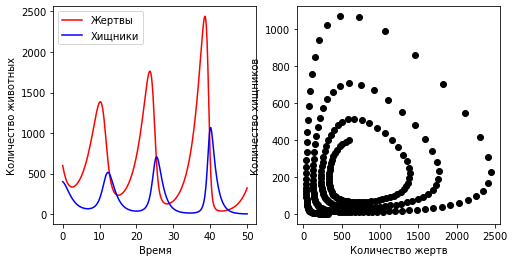

In [132]:
#Параметры a,b,c,d и задание функции f возьмем тем же
def f1(x, y):
    return [a*x - b*x*y, c*x*y - d*y]

def first_RK(f, xy0, start, stop, num):
    h = (stop-start)/num #num отвечает за число узлов, считала num 
    #я по формуле из предыдущей части, только вместо периода выступает уже весь отрезок
    xy = np.zeros(shape=(2,num))
    #xy[0][0] = xy0[0]
    #xy[1][0] = xy0[1]
    xy[:,0]=xy0
    for i in range(num-1):
        k1 = f(xy[0][i], xy[1][i])
        xy[0][i+1] = xy[0][i]+h*k1[0]
        xy[1][i+1] = xy[1][i]+h*k1[1]
    return xy
# начальные условия
xy_vec0 = [600, 400]
start = 0
stop = 50
num = int(1000*b*(stop-start)/a)
t = np.linspace(start, stop, num)
xy_t = first_RK(f1, xy_vec0, start, stop, num)
#print(xy_t)
print("Рассчитанное количество узлов", num)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(t, xy_t[0,:], 'r', label="Жертвы")
axes[0].plot(t, xy_t[1,:], 'b', label="Хищники")
axes[0].set_xlabel("Время")
axes[0].set_ylabel("Количество животных")
axes[0].legend()
axes[1].plot(xy_t[0,:], xy_t[1,:], 'ko')
axes[1].set_xlabel("Количество жертв")
axes[1].set_ylabel("Количество хищников")

Для третьего порядка аналогично оценим число узлов
$$ \dfrac{T^3}{N^3}= h^3\approx 0,001\dfrac{a}{b}$$
$$N = 10T\sqrt[3]{\dfrac{b}{a}}$$

Рассчитанное количество узлов 85


Text(0.5, 1.0, 'Решение с помощью odeint')

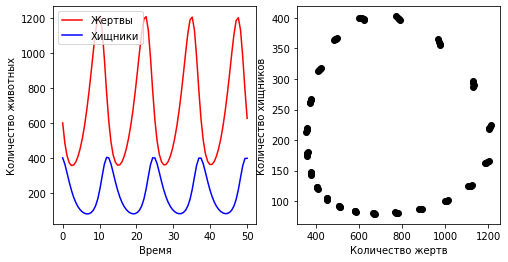

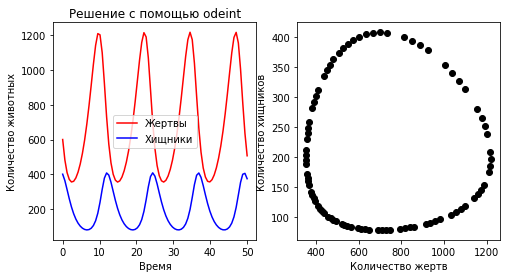

In [131]:
def third_RK(f, xy0, start, stop, num):
    h = (stop-start)/num
    xy = np.zeros(shape=(2,num))
    xy[:,0]=xy0
    for i in range(num-1):
        k1 = f(xy[0][i], xy[1][i])
        k2 = f(xy[0][i] + (h/2)*k1[0], xy[1][i] + (h/2)*k1[1])
        k3 = f(xy[0][i] - h*k1[0]+2*h*k2[0], xy[1][i] - h*k1[1]+2*h*k2[1])
        xy[0][i+1] = xy[0][i]+(h/6)*(k1[0]+4*k2[0]+k3[0])
        xy[1][i+1] = xy[1][i]+(h/6)*(k1[1]+4*k2[1]+k3[1])
    return xy
# начальные условия
xy_vec0 = [600, 400]
start = 0
stop = 50
num = int(10*(stop-start)*((b/a)**(1./3.)))
t = np.linspace(start, stop, num)
xy_t = third_RK(f1, xy_vec0, start, stop, num)
#print(xy_t)
print("Рассчитанное количество узлов", num)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(t, xy_t[0,:], 'r', label="Жертвы")
axes[0].plot(t, xy_t[1,:], 'b', label="Хищники")
axes[0].set_xlabel("Время")
axes[0].set_ylabel("Количество животных")
axes[0].legend()
axes[1].plot(xy_t[0,:], xy_t[1,:], 'ko')
axes[1].set_xlabel("Количество жертв")
axes[1].set_ylabel("Количество хищников")

t1 = np.linspace(0, 50, num)
# решение пакетным методом
xy1_t = integrate.odeint(f, xy_vec0, t1)
fig1, axes1 = plt.subplots(1, 2, figsize=(8, 4))
axes1[0].plot(t1, xy1_t[:,0], 'r', label="Жертвы")
axes1[0].plot(t1, xy1_t[:,1], 'b', label="Хищники")
axes1[0].set_xlabel("Время")
axes1[0].set_ylabel("Количество животных")
axes1[0].legend()
axes1[1].plot(xy1_t[:,0], xy1_t[:,1], 'ko')
axes1[1].set_xlabel("Количество жертв")
axes1[1].set_ylabel("Количество хищников")
axes1[0].set_title("Решение с помощью odeint")

### Часть 3. Порядок точности метода

Найти численно и построить графики порядка методов из предыдущей части в зависимости от шага сетки в широком диапазоне шага. Объяснить, что мы видим на рисунке. 

**Решение**
По аналогии с предыдущими пунктами:
$$ h^k \approx 0,001\dfrac{a}{b}$$
Откуда
$$ k = \dfrac{\log_2(0,001\frac{a}{b})}{\log_2(h)}$$

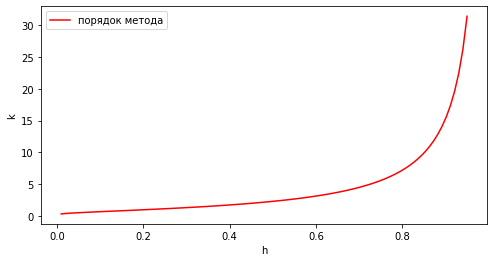

In [125]:
import math
num=99
h = np.linspace(0.01, 0.95, num)
k = [0]*num
for i in range(99):
    k[i] = abs(math.log2(0.001*a/b)/math.log2(h[i]))
#print(k)
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(h, k, 'r', label="порядок метода")
ax.set_xlabel("h")
ax.set_ylabel("k")
ax.legend()

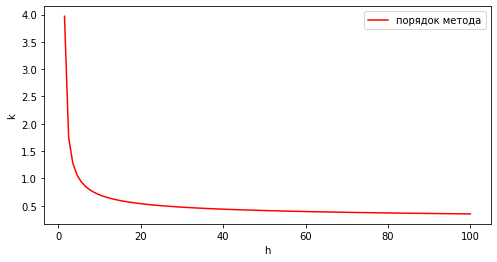

In [128]:
num=99
h = np.linspace(1.5, 100, num)
k = [0]*num
for i in range(99):
    k[i] = abs(math.log2(0.001*a/b)/math.log2(h[i]))
#print(k)
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(h, k, 'r', label="порядок метода")
ax.set_xlabel("h")
ax.set_ylabel("k")
ax.legend()

В общем-то очень странную картинку видим, пока сама не понимаю, что это. Логике поддается объяснению только вторая картинка, где $h\in(1;100)$ (тут просто порядок уменьшается при увеличении шага). С первой проблемы, скорее всего потому что я при аппроксимации опускаю константу, а при очень маленьких $h$ она будет заметна, поэтому тут нужно оценивать другими способами.